# Pre-Processing
In the Preprocessing stage, I will first split the dataset into training and testing sets to ensure that the models can be properly trained and evaluated on separate data. The training set is used to fit and optimize the supervised classification models, while the testing set is reserved for assessing their predictive performance.  

Next, I create preprocessing pipelines for both numeric and categorical features. The numeric transformer uses an `SimpleImputer` to fill in missing values based on the medians of the numeric variables, followed by a `StandardScaler` to normalize their ranges. The categorical transformer also uses an `SimpleImputer` with the most frequent category strategy to handle missing values and then applies a `OneHotEncoder` to convert categorical features into numerical format suitable for modeling. These transformations are combined within a `ColumnTransformer` to ensure that each feature type is processed appropriately and consistently, producing a clean and fully prepared dataset for model training.

### Import Python Packages & Dataset

In [1]:
# %load_ext cudf.pandas
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline  as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()

# Define column types
categorical_columns = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
 ]
numeric_columns = [
    'age',
    'fnlwgt',
    'education-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
 ]

# Import dataset that was created in the '5509_income_pre_modeling.ipynb' workbook
df = pd.read_csv('./df.csv')

In [2]:
# Downcast floats datatypes to minimize memory usage 
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

# Downcast interger datatypes to minimize memory usage 
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# Instantiate an empty dataframe that will be used to store each models precision, recall, and F1 scores by target category
model_results_df = pd.DataFrame([])

# Instantiate an empty dataframe that will be used to store each models AUC
model_roc_auc_df = pd.DataFrame([])

# Change categorical columns to category datatype
# df[categorical_columns] = df[categorical_columns].astype('category')

### Train Test Split
- The dataset is now divided into a training set that will be used to build supervised classification models, and a testing set for evaluating their performance.

In [3]:
# Define the predictors
X = df[['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']]

# Define the target
y = df['income']

# Drop the target from the categorical_columns list
categorical_columns = [col for col in categorical_columns if col != 'income']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check shape of X_train, X_test, y_train, & y_test
print(f'X_train shape = {X_train.shape}    y_train shape = {y_train.shape}')
print(f'X_test shape =  {X_test.shape}     y_test shape =  {y_test.shape}')

X_train shape = (39050, 13)    y_train shape = (39050,)
X_test shape =  (9763, 13)     y_test shape =  (9763,)


### Preprocessing Transformers
- Next we build a preprocessing pipeline that prepares numeric and categorical data for modeling. Numeric features are imputed using their median values and standardized for consistent scaling, while categorical features are imputed with the most frequent category and one-hot encoded into binary variables. The `ColumnTransformer` then applies these transformations to their respective columns, producing a clean, model-ready dataset.
- To aid in modeling dummy columns will be added during imputing to indicate where data was missing for the `capital-gain`, `capital-loss`, `workclass`, `occupation`, and `native-country` columns.

In [4]:
numeric_transformer = SkPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = SkPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'
)

### Preprocessing - Conclusions/Discussions/Next Steps:
During preprocessing, the main challenge identified was ensuring that the imputation process accurately captured relationships among variables without introducing bias, especially given the number of missing values in both numeric and categorical features.  

With the data now standardized and encoded, the next step will be to apply supervised learning models to classify `income` levels and evaluate their performance on the testing set.

# Base Classifiers Modeling
In the Modeling section, I first define several helper functions to streamline the evaluation process by generating learning curves, classification reports, confusion matrices, ROC curves, and feature selection summaries.  

Three supervised classification models are developed:
- a Logistic Regression model to estimate class probabilities using a sigmoid function,
- a Support Vector Classifier (SVC) to separate classes by finding the optimal decision boundary, and
- a Random Forest Classifier to aggregate multiple decision trees for improved accuracy and robustness.

Each model is trained using the preprocessed training data and evaluated on the test set to measure performance.  

Finally, ROC curves are plotted to compare all three classifiers and visually assess their ability to distinguish between `income` classes.

### Modeling Helper Functions
- These helper functions are used to evaluate model performance by:
  - Fitting the model (`fit_model` function)
  - Plotting the learning curve plots (`plot_learning_curve` function)
  - Generating classification tables and confusion matrices (`create_classification_output` function)
  - Plot ROC curves (`make_roc_curves` function)
- There are also functions used to:
  - Identify dropped columns during feature selection (`showdropped_features` function)
  - Extract the best hyperparameters from cross-validation (`best_params_for` function)

In [5]:
# Function to check if a model has already been fit then load the model, otherwise fit the model
def fit_model(pipe, X_train, y_train, filename):
    if os.path.exists(filename):
        print(f'Loading saved model from {filename}')
        fitted_model = joblib.load(filename)
    else:
        fitted_model = pipe.fit(X_train, y_train)
        joblib.dump(fitted_model, filename)
        print(f'Model fitted and saved to {filename}')
    return fitted_model

# Function to plot the learning curve for a given model
def plot_learning_curve(estimator, X, y, clf_type):
    print('\n' + '=' * 110)
    print(f'{clf_type} Learning Curve:')
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=1,
        train_sizes=np.linspace(0.2, 1.0, 5),
        shuffle=True,
        random_state=42,
    )
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 'o-', label='Training')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training set size')
    plt.ylabel('ROC AUC')
    plt.title(f'Learning Curve (ROC AUC)\n({clf_type})')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to output the classification report and confusion matrix for a given model
def create_classification_output(pipe, y_test, y_pred, clf_type):
    # Create classification report
    print('\n' + '=' * 110)
    print(f'{clf_type} Report:\n{classification_report(y_test, y_pred, digits=4)}')
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)

    # Append model results to the model_results_df
    temp_result_df = pd.DataFrame.from_dict(
        {k:v for k,v in report.items() if k in ['<=50K', '>50K']},
        orient='index'
    ).reset_index(names='income')
    temp_result_df['model'] = clf_type
    global model_results_df
    model_results_df = pd.concat([model_results_df, temp_result_df])
    # Append model roc_auc to the model_roc_auc_df
    if hasattr(pipe, 'predict_proba'):
        print(hasattr(pipe, 'predict_proba'))   
        y_score = pipe.predict_proba(X_test)[:, 1]
    else:
        y_score = pipe.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    print(f'The {clf_type} ROC AUC = {auc:.4f}')
    temp_roc_auc_df = pd.DataFrame.from_dict(
            {clf_type:auc},
            orient='index',
            columns=['roc_auc']
        ).reset_index(names='model')
    global model_roc_auc_df
    model_roc_auc_df = pd.concat([model_roc_auc_df, temp_roc_auc_df])

    # Plot confusion matrix
    print('\n' + '=' * 110)
    print(f'{clf_type} Confusion Matrix:')
    labels = ['<=50K', '>50K']
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Test Data Confusion Matrix\n({clf_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curves and a AUC summary chart to compare models
def make_roc_curves(X_test, y_test, models):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
    aucs, colors = {}, {}

    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        aucs[name] = roc_auc_score(y_test, y_score)
        disp = RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax1, pos_label='>50K')
        colors[name] = disp.line_.get_color()

    # ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--', label='Chance')
    ax1.set_title('ROC Curves')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, fontsize=9)

    # AUC Summary Chart
    names, scores = zip(*sorted(aucs.items(), key=lambda kv: kv[1], reverse=True))
    bar_colors = [colors[n] for n in names]
    bars = ax2.bar(range(len(names)), scores, color=bar_colors)
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=90, ha='center')
    ax2.set_ylabel('AUC'); ax2.set_ylim(0.8, 1.0); ax2.set_title('AUC by Model Type')
    for rect, s in zip(bars, scores):
        ax2.text(rect.get_x() + rect.get_width()/2.0, rect.get_height() + 0.005, f'{s:.3f}',
                 ha='center', va='bottom', fontsize=9)
    fig.tight_layout(); fig.subplots_adjust(bottom=0.25)
    plt.show()

# Function to show which features are being dropped during feature selection
def show_dropped_features(pipe, clf_type):
    preprocess = pipe.named_steps['preprocessor']
    selector = pipe.named_steps['selector']

    feature_names = preprocess.get_feature_names_out()
    kept_mask = selector.get_support()
    coef = getattr(selector.estimator_, 'coef_', None)
    l1_importance = np.abs(coef).ravel() if coef is not None else np.zeros_like(kept_mask, dtype=float)

    selector_df = (
        pd.DataFrame({
            'feature': feature_names,
            'kept': kept_mask,
            'l1_importance': l1_importance
        })
        .assign(status=lambda d: np.where(d.kept, 'kept', 'dropped'))
        .sort_values(['kept', 'l1_importance'], ascending=[False, False])
        .reset_index(drop=True)
    )

    print('=' * 110)
    print(f'{clf_type} Feature Selection:')
    print(f'\n{kept_mask.sum()} of the {kept_mask.size} features are used in modeling\n')
    print('Features dropped from model:')
    for feat in selector_df.loc[~selector_df['kept'], 'feature']:
        print(f'\t{feat}')

# Function to extract the best model hyperparameters from cross-validation
def best_params_for(results, name):
    mask = results['param_classifier'].astype(str).str.contains(name)
    row = results[mask].sort_values('rank_test_score').iloc[0].dropna()
    params = {k: row[k] for k in row.index if k.startswith('param_')}
    params = {k.replace('param_', ''): v for k, v in params.items()}
    return params

### Logistic Classifier
- A Logistic Classifier predicts the probability that an observation belongs to a particular class by modeling the relationship between input features and a binary outcome using a logistic (sigmoid) function.

Loading saved model from logistic_pipe.pkl

Logistic Classification (base model) Learning Curve:


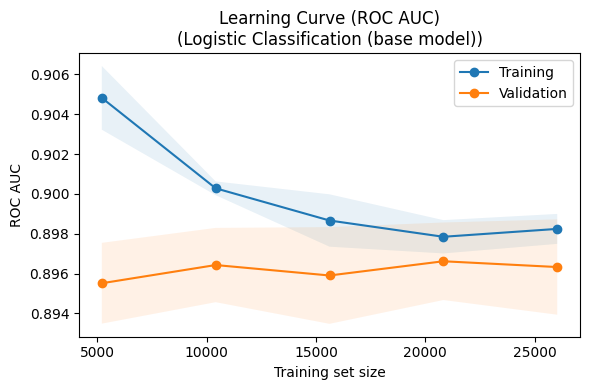


Logistic Classification (base model) Report:
              precision    recall  f1-score   support

       <=50K     0.8761    0.9306    0.9026      7426
        >50K     0.7253    0.5819    0.6458      2337

    accuracy                         0.8472      9763
   macro avg     0.8007    0.7563    0.7742      9763
weighted avg     0.8400    0.8472    0.8411      9763

True
The Logistic Classification (base model) ROC AUC = 0.8953

Logistic Classification (base model) Confusion Matrix:


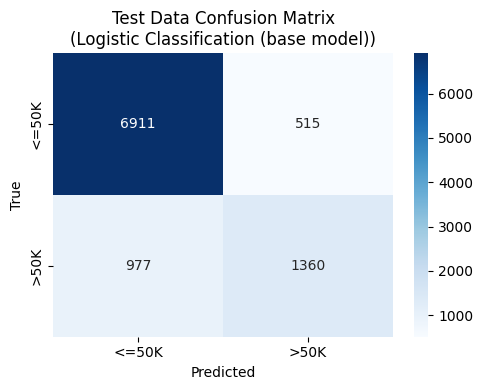

In [6]:
# Define classifier type
clf_type = 'Logistic Classification (base model)'

# Create logistic classifier pipeline instance
logistic_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_pipe = fit_model(logistic_pipe, X_train, y_train, 'logistic_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_pipe.predict(X_test)

# Create classification output
create_classification_output(logistic_pipe, y_test, y_pred, clf_type)

> The Logistic Classification base model achieved solid performance with an ROC AUC of 0.895, an overall accuracy of 84.7%, and strong recall for the <=50K class (93.1%), though it underperformed on the >50K class (recall = 58.9%). The learning curve suggests mild overfitting but stable generalization as the training size increases.

### Support Vector Classifier
- A Support Vector Classifier (SVC) separates classes by finding the optimal hyperplane that maximizes the margin between them, making it effective for both linear and non-linear classification problems.

Loading saved model from svc_pipe.pkl

Support Vector Classifier (base model) Learning Curve:


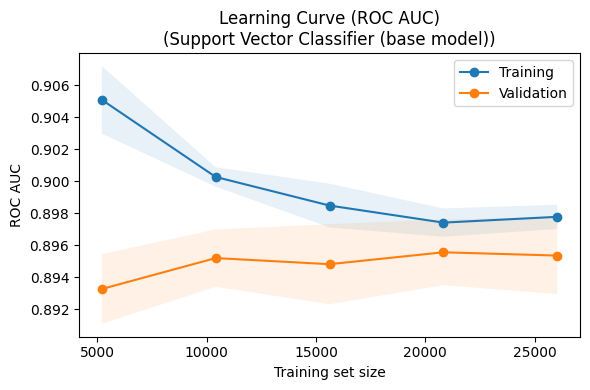


Support Vector Classifier (base model) Report:
              precision    recall  f1-score   support

       <=50K     0.9396    0.7746    0.8491      7426
        >50K     0.5402    0.8417    0.6581      2337

    accuracy                         0.7906      9763
   macro avg     0.7399    0.8081    0.7536      9763
weighted avg     0.8440    0.7906    0.8034      9763

The Support Vector Classifier (base model) ROC AUC = 0.8947

Support Vector Classifier (base model) Confusion Matrix:


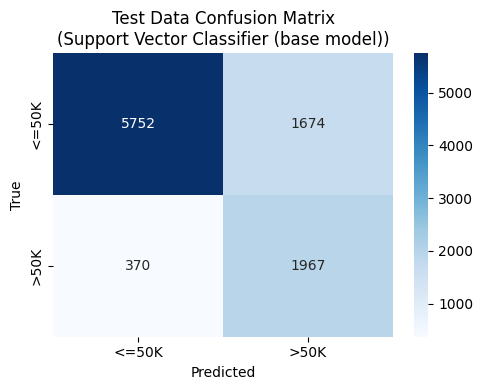

In [7]:
# Define classifier type
clf_type = 'Support Vector Classifier (base model)'

# Create logistic classifier pipeline instance
svc_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', LinearSVC(class_weight='balanced', dual='auto', random_state=42))
])

# Fit model
svc_pipe = fit_model(svc_pipe, X_train, y_train, 'svc_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_pipe, y_test, y_pred, clf_type)

> The Support Vector Classifier base model achieved an ROC AUC of 0.895 and an accuracy of 79.1%. It showed strong recall for the >50K class (84.2%) but lower precision, indicating a trade-off between correctly identifying higher-income individuals and misclassifying some from the lower-income group.

### Random Forest Classifier
- A Random Forest Classifier builds an ensemble of decision trees on random subsets of the data and averages their predictions to improve accuracy and reduce overfitting.

Loading saved model from rf_pipe.pkl

Random Forest Classifier (base model) Learning Curve:


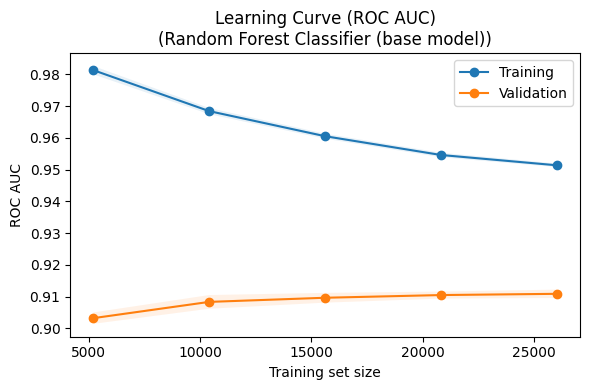


Random Forest Classifier (base model) Report:
              precision    recall  f1-score   support

       <=50K     0.8742    0.9535    0.9121      7426
        >50K     0.7925    0.5640    0.6590      2337

    accuracy                         0.8603      9763
   macro avg     0.8334    0.7588    0.7856      9763
weighted avg     0.8547    0.8603    0.8516      9763

True
The Random Forest Classifier (base model) ROC AUC = 0.9121

Random Forest Classifier (base model) Confusion Matrix:


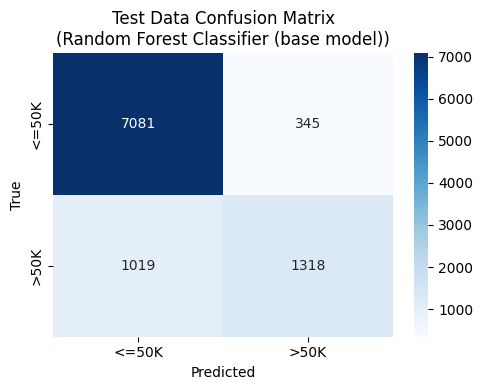

In [8]:
# Define classifier type
clf_type = 'Random Forest Classifier (base model)'

# Create random forest classifier pipeline instance
rf_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_pipe = fit_model(rf_pipe, X_train, y_train, 'rf_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_pipe.predict(X_test)

# Create classification output
create_classification_output(rf_pipe, y_test, y_pred, clf_type)

> The Random Forest Classifier base model achieved the highest ROC AUC of 0.912 and an accuracy of 86.0%, showing strong predictive performance overall. However, the learning curve reveals substantial overfitting, as training performance remains near-perfect while validation improvement plateaus, with continued weakness in recall for the >50K class (56.4%).

### ROC Curves - Base Classifier Models
- An ROC curve (Receiver Operating Characteristic curve) shows how well each classifier distinguishes between the positive and negative classes across different threshold values. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity), allowing you to visualize the trade-off between correctly identifying positives and incorrectly classifying negatives. When the logistic, support vector, and random forest classifiers are displayed on the same ROC curve, the one with a line closer to the top-left corner demonstrates better overall performance and a higher ability to separate the two classes.

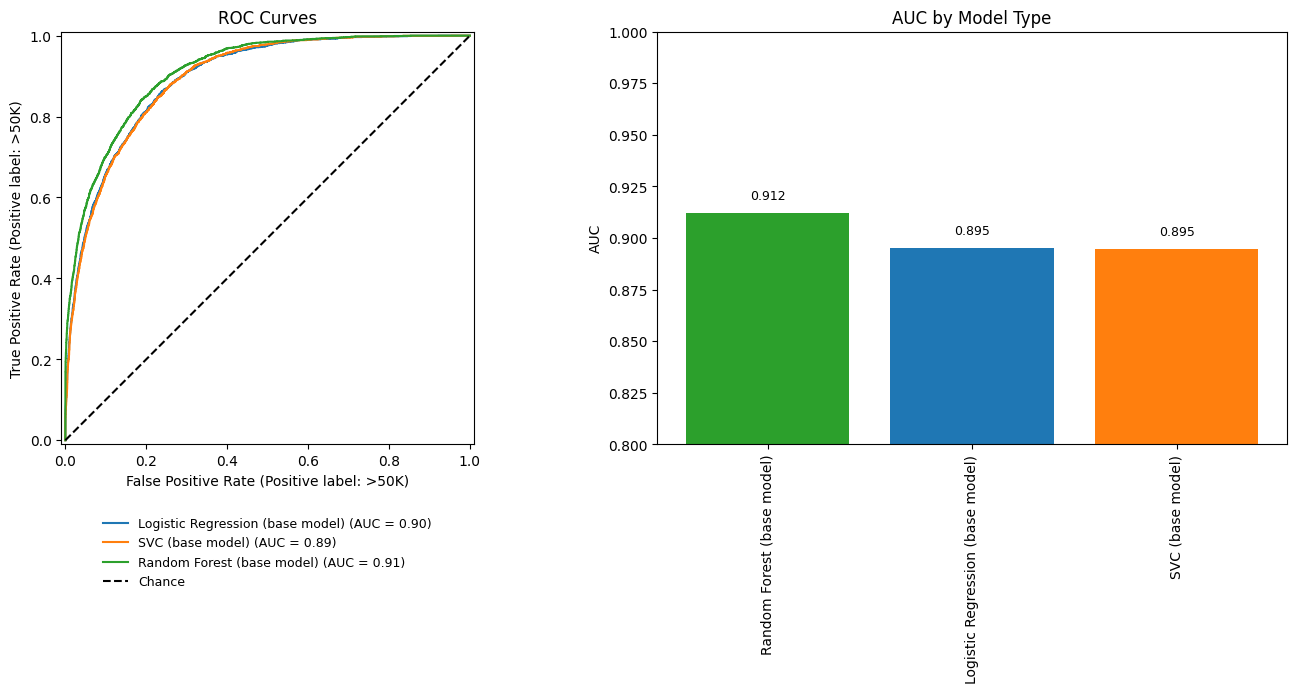

In [9]:
base_classifier_models = {
    'Logistic Regression (base model)':  logistic_pipe,
    'SVC (base model)':                  svc_pipe,
    'Random Forest (base model)':        rf_pipe,
}
make_roc_curves(X_test, y_test, base_classifier_models)

> Among the base models, the Random Forest Classifier achieved the highest ROC AUC of 0.912, outperforming both Logistic Regression and the Support Vector Classifier, which each scored 0.895. This indicates that the Random Forest model provided the strongest overall class separation and predictive capability on the dataset.

### Modeling - Conclusions/Discussions/Next Steps:
The modeling results showed that all three classifiers performed well, with Logistic Regression achieving the highest AUC (0.908) and accuracy (85.9%), followed closely by SVC and Random Forest. However, each model consistently performed better at predicting ≤50K incomes than >50K, suggesting class imbalance or overlapping feature distributions could limit precision for higher-income predictions.  

The next step, Feature Selection, will focus on identifying the most influential variables to simplify the models, improve computational efficiency, and reduce potential overfitting.

# Over-Sampling
Imbalanced datasets can influence both how a machine learning model learns and how accurately it makes predictions. This imbalance occurs when one class contains significantly more samples than the other, leading the model’s decision boundary to lean toward the majority class and underrepresents the minority class. Here we will test if we can increase the accuracy of the base classifier models by applying the SMOTE over-sampling technique.

### Logistic Classifier (with over-sampling)
- Applying SMOTE to the logistic model helps correct class imbalance by generating synthetic minority samples, allowing the model to learn a more balanced decision boundary and improve recall for the underrepresented >50K class.

Loading saved model from logistic_resample_pipe.pkl

Logistic Classification (with over-sampling) Learning Curve:


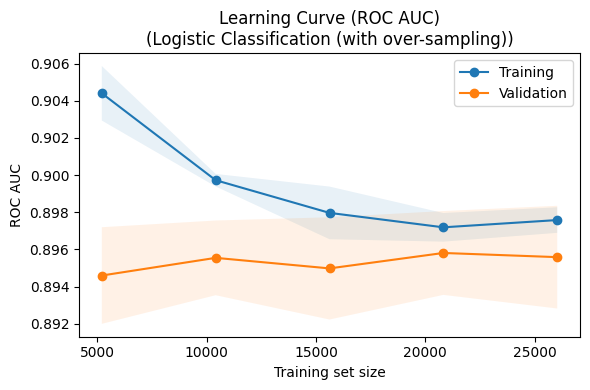


Logistic Classification (with over-sampling) Report:
              precision    recall  f1-score   support

       <=50K     0.9352    0.7890    0.8559      7426
        >50K     0.5520    0.8263    0.6619      2337

    accuracy                         0.7979      9763
   macro avg     0.7436    0.8076    0.7589      9763
weighted avg     0.8435    0.7979    0.8094      9763

True
The Logistic Classification (with over-sampling) ROC AUC = 0.8942

Logistic Classification (with over-sampling) Confusion Matrix:


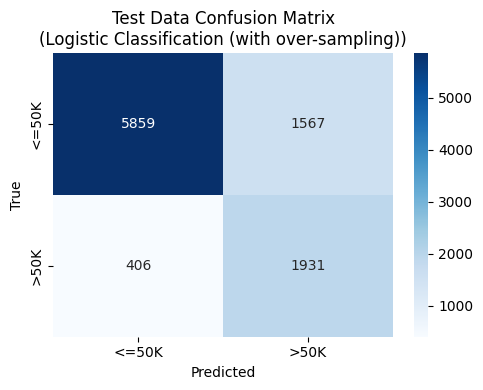

In [10]:
# Define classifier type
clf_type = 'Logistic Classification (with over-sampling)'

# Create logistic classifier pipeline instance
logistic_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_resample_pipe = fit_model(logistic_resample_pipe, X_train, y_train, 'logistic_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(logistic_resample_pipe, y_test, y_pred, clf_type)

> The Logistic Classification model with over-sampling achieved an ROC AUC of 0.894 and accuracy of 79.8%. While precision declined slightly, recall for the minority >50K class improved to 82.6%, showing that over-sampling effectively enhanced sensitivity and reduced bias toward the majority class.

### Support Vector Classifier (with over-sampling)
- SMOTE aids the SVC in finding a more equitable hyperplane between classes by providing a denser representation of the minority class, reducing bias toward the majority class and improving generalization on imbalanced data.

Loading saved model from svc_resample_pipe.pkl

Support Vector Classifier (with over-sampling) Learning Curve:


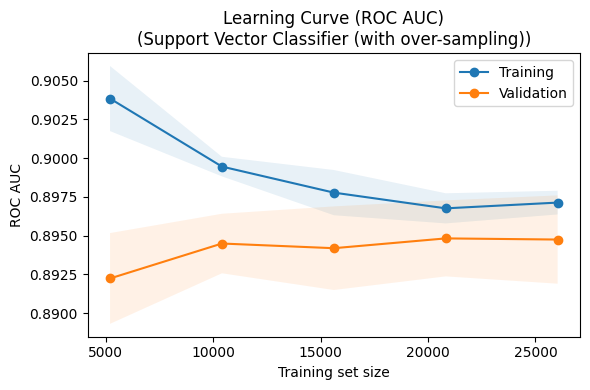


Support Vector Classifier (with over-sampling) Report:
              precision    recall  f1-score   support

       <=50K     0.9371    0.7800    0.8513      7426
        >50K     0.5438    0.8335    0.6582      2337

    accuracy                         0.7928      9763
   macro avg     0.7404    0.8068    0.7548      9763
weighted avg     0.8429    0.7928    0.8051      9763

The Support Vector Classifier (with over-sampling) ROC AUC = 0.8936

Support Vector Classifier (with over-sampling) Confusion Matrix:


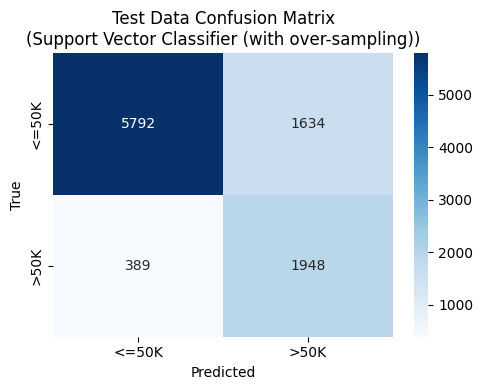

In [11]:
# Define classifier type
clf_type = 'Support Vector Classifier (with over-sampling)'

# Create support vector classifier pipeline instance
svc_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', LinearSVC(dual='auto', random_state=42))
])

# Fit model
svc_resample_pipe = fit_model(svc_resample_pipe, X_train, y_train, 'svc_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_resample_pipe, y_test, y_pred, clf_type)

> After applying SMOTE, the Logistic Classification model achieved an ROC AUC of 0.894 with a balanced improvement in recall for the >50K class (83.4%) at the expense of some accuracy (79.3%). The learning curve shows slightly reduced overfitting and better representation of the minority class, though precision dropped due to the synthetic oversampling.

### Random Forest Classifier (with over-sampling)
- Although Random Forest is relatively robust to imbalance, applying SMOTE can still improve performance by ensuring minority samples are adequately represented across tree splits, potentially enhancing minority class recall without severely increasing overfitting risk.

Loading saved model from rf_resample_pipe.pkl

Random Forest Classifier (with over-sampling) Learning Curve:


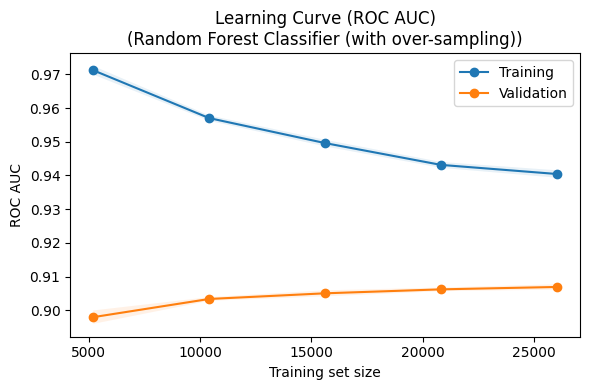


Random Forest Classifier (with over-sampling) Report:
              precision    recall  f1-score   support

       <=50K     0.9356    0.8074    0.8668      7426
        >50K     0.5736    0.8233    0.6762      2337

    accuracy                         0.8112      9763
   macro avg     0.7546    0.8154    0.7715      9763
weighted avg     0.8489    0.8112    0.8212      9763

True
The Random Forest Classifier (with over-sampling) ROC AUC = 0.9060

Random Forest Classifier (with over-sampling) Confusion Matrix:


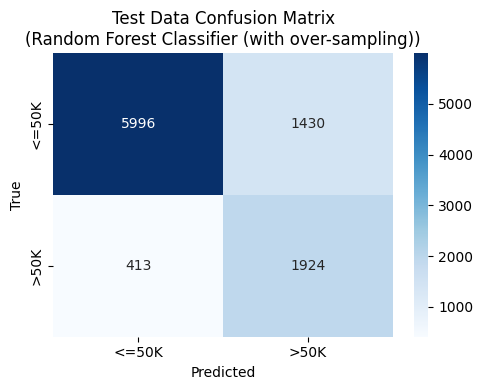

In [12]:
# Define classifier type
clf_type = 'Random Forest Classifier (with over-sampling)'

#  Create random forest classifier pipeline instance
rf_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_resample_pipe = fit_model(rf_resample_pipe, X_train, y_train, 'rf_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(rf_resample_pipe, y_test, y_pred, clf_type)

> With SMOTE applied, the Random Forest Classifier achieved an ROC AUC of 0.906 and accuracy of 81.1%, showing better balance between the two income classes. The model’s recall for the >50K class improved markedly to 82.3%, though precision declined, indicating stronger sensitivity to minority cases at the cost of more false positives.

### ROC Curves - Over-Sampling
- Comparing the base classifiers to the classifiers that have had over-sampling applied.

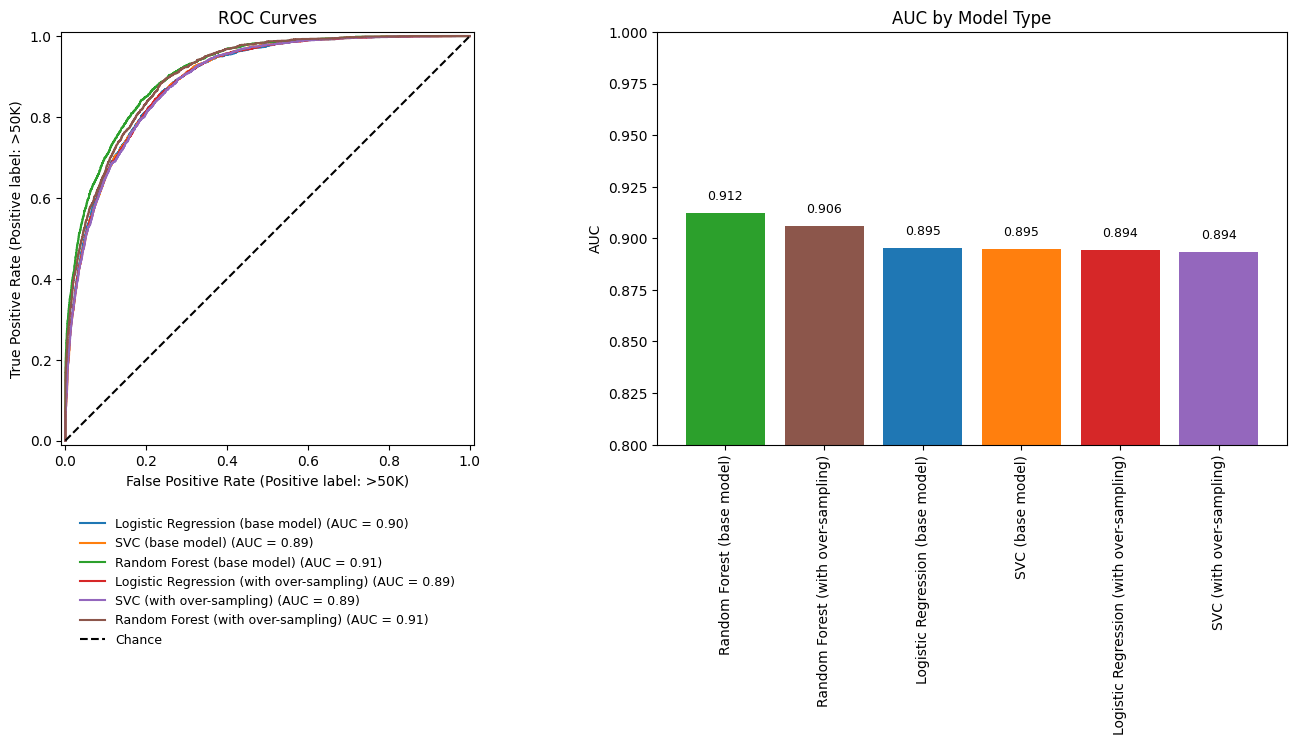

In [13]:
base_and_resample_classifier_models = {
    'Logistic Regression (base model)':         logistic_pipe,
    'SVC (base model)':                         svc_pipe,
    'Random Forest (base model)':               rf_pipe,
    'Logistic Regression (with over-sampling)': logistic_resample_pipe,
    'SVC (with over-sampling)':                 svc_resample_pipe,
    'Random Forest (with over-sampling)':       rf_resample_pipe,
}
make_roc_curves(X_test, y_test, base_and_resample_classifier_models)

> All models achieved strong ROC AUC scores between 0.89 and 0.91, showing consistent predictive performance across methods. The Random Forest Classifier, both with and without over-sampling, led with an AUC of 0.912 and 0.906 respectively, confirming its superior ability to distinguish between income classes while maintaining stability after balancing.

# Feature Selection
This is the process of identifying and keeping only the most relevant input variables that contribute significantly to a model’s predictions. In supervised classification, this helps improve model performance, reduce overfitting, and make the model more efficient by removing redundant or irrelevant features.

### Logistic Classifier (with feature selection)
- Now we train a logistic regression pipeline that preprocesses the data, performs feature selection using an L1-regularized logistic model to drop less important features, and then fits a logistic regression classifier to the preprocessed and feature selected dataset.

Loading saved model from logistic_fs_pipe.pkl

Logistic Classification (with feature selection) Learning Curve:


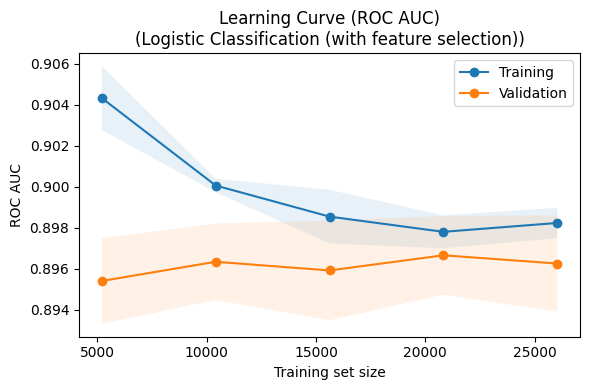

Logistic Classification (with feature selection) Feature Selection:

70 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Local-gov
	cat__workclass_Never-worked
	cat__marital-status_Married-spouse-absent
	cat__occupation_Armed-Forces
	cat__occupation_Craft-repair
	cat__relationship_Unmarried
	cat__race_Other
	cat__race_White
	cat__native-country_Ecuador
	cat__native-country_El-Salvador
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Jamaica
	cat__native-country_Japan
	cat__native-country_Nicaragua
	cat__native-country_Outlying-US(Guam-USVI-etc)
	cat__native-country_Poland


In [14]:
# Define classifier type
clf_type = 'Logistic Classification (with feature selection)'

# Create logistic classifier pipeline instance
logistic_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, random_state=42))),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_fs_pipe = fit_model(logistic_fs_pipe, X_train, y_train, 'logistic_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_fs_pipe, clf_type)


Logistic Classification (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.8764    0.9309    0.9028      7426
        >50K     0.7264    0.5828    0.6467      2337

    accuracy                         0.8476      9763
   macro avg     0.8014    0.7569    0.7748      9763
weighted avg     0.8405    0.8476    0.8415      9763

True
The Logistic Classification (with feature selection) ROC AUC = 0.8953

Logistic Classification (with feature selection) Confusion Matrix:


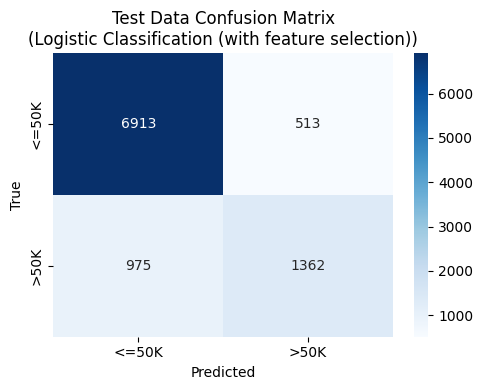

In [15]:
# Create classification output
create_classification_output(logistic_fs_pipe, y_test, y_pred, clf_type)

> After applying feature selection, the logistic regression model achieved an accuracy of 84.8%, maintaining similar performance to the base model while using fewer features. The model continued to predict ≤50K incomes with high recall (93.1%) but showed lower recall (58.2%) for >50K, indicating it generalizes well but may still under-identify higher-income individuals.

### Support Vector Classifier (with feature selection)
- This code builds and trains a support vector classifier pipeline that preprocesses the data, uses an L1-regularized linear SVC to select the most important features, and then fits an RBF-kernel SVC for final classification..

Loading saved model from svc_fs_pipe.pkl

Support Vector Classifier (with feature selection) Learning Curve:


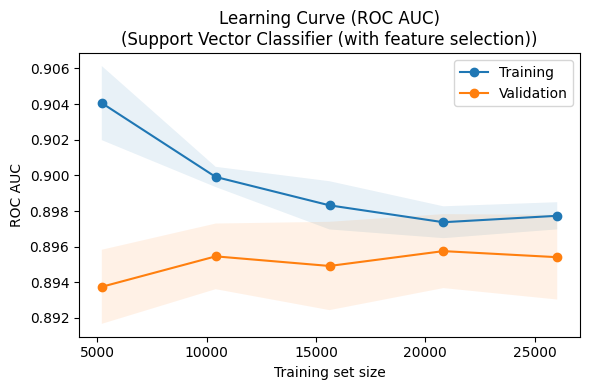

Support Vector Classifier (with feature selection) Feature Selection:

75 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Never-worked
	cat__workclass_Self-emp-inc
	cat__occupation_Armed-Forces
	cat__relationship_Husband
	cat__race_Other
	cat__native-country_Cuba
	cat__native-country_Ecuador
	cat__native-country_El-Salvador
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Jamaica
	cat__native-country_Japan
	cat__native-country_Outlying-US(Guam-USVI-etc)


In [16]:
# Define classifier type
clf_type = 'Support Vector Classifier (with feature selection)'

# Create logistic classifier pipeline instance
svc_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LinearSVC(penalty='l1', dual=False, C=0.25, tol=1e-3, max_iter=50000, random_state=42))),
    ('classifier', LinearSVC(class_weight='balanced', dual='auto', random_state=42))
])

# Fit model
svc_fs_pipe = fit_model(svc_fs_pipe, X_train, y_train, 'svc_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(svc_fs_pipe, clf_type)


Support Vector Classifier (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.9396    0.7744    0.8490      7426
        >50K     0.5401    0.8417    0.6580      2337

    accuracy                         0.7905      9763
   macro avg     0.7398    0.8081    0.7535      9763
weighted avg     0.8439    0.7905    0.8033      9763

The Support Vector Classifier (with feature selection) ROC AUC = 0.8946

Support Vector Classifier (with feature selection) Confusion Matrix:


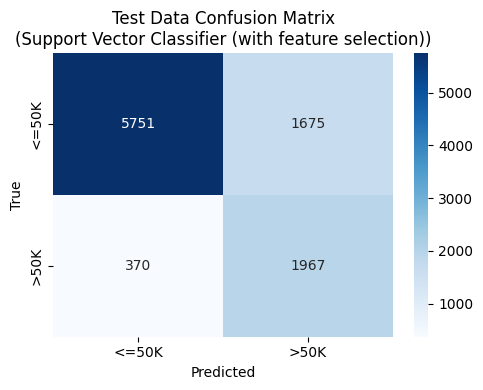

In [17]:
# Create classification output
create_classification_output(svc_fs_pipe, y_test, y_pred, clf_type)

> The Support Vector Classifier with feature selection achieved an ROC AUC of 0.895 and an accuracy of 79.1%. Feature selection streamlined the model while maintaining strong recall for the >50K class (84.2%), indicating that reducing features preserved discriminative power and improved computational efficiency without sacrificing performance.

### Random Forest Classifier (with feature selection)
- This code creates and trains a random forest pipeline that preprocesses the data, selects important features based on feature importance scores from an initial random forest, and then fits a final random forest classifier using those selected features.

Loading saved model from rf_fs_pipe.pkl

Random Forest Classifier (with feature selection) Learning Curve:


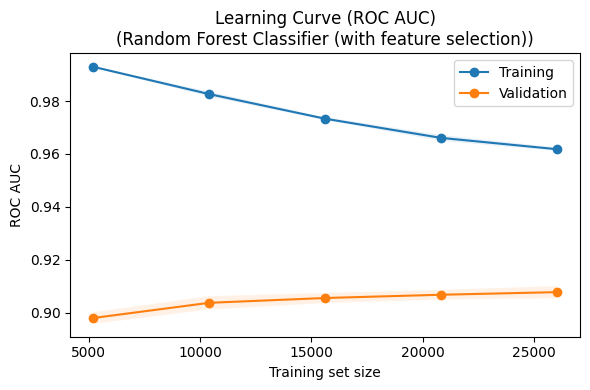

Random Forest Classifier (with feature selection) Feature Selection:

11 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Federal-gov
	cat__workclass_Local-gov
	cat__workclass_Never-worked
	cat__workclass_Private
	cat__workclass_Self-emp-inc
	cat__workclass_Self-emp-not-inc
	cat__workclass_State-gov
	cat__workclass_Without-pay
	cat__marital-status_Divorced
	cat__marital-status_Married-AF-spouse
	cat__marital-status_Married-spouse-absent
	cat__marital-status_Separated
	cat__marital-status_Widowed
	cat__occupation_Adm-clerical
	cat__occupation_Armed-Forces
	cat__occupation_Craft-repair
	cat__occupation_Farming-fishing
	cat__occupation_Handlers-cleaners
	cat__occupation_Machine-op-inspct
	cat__occupation_Other-service
	cat__occupation_Priv-house-serv
	cat__occupation_Protective-serv
	cat__occupation_Sales
	cat__occupation_Tech-support
	cat__occupation_Transport-moving
	cat__relationship_Not-in-family
	cat__relationship_Other-relative
	cat__relationship

In [18]:
# Define classifier type
clf_type = 'Random Forest Classifier (with feature selection)'

# Create random forest classifier pipeline instance
rf_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_fs_pipe = fit_model(rf_fs_pipe, X_train, y_train, 'rf_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(rf_fs_pipe, clf_type)


Random Forest Classifier (with feature selection) Report:
              precision    recall  f1-score   support

       <=50K     0.8772    0.9453    0.9100      7426
        >50K     0.7693    0.5794    0.6610      2337

    accuracy                         0.8577      9763
   macro avg     0.8232    0.7624    0.7855      9763
weighted avg     0.8514    0.8577    0.8504      9763

True
The Random Forest Classifier (with feature selection) ROC AUC = 0.9124

Random Forest Classifier (with feature selection) Confusion Matrix:


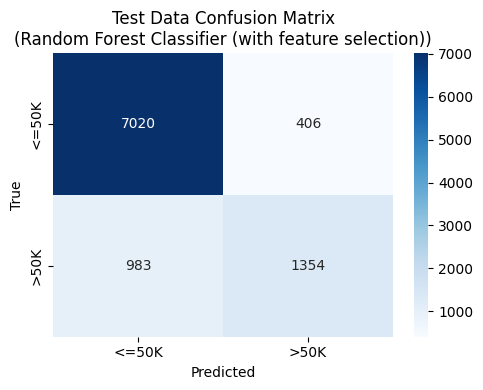

In [19]:
# Create classification output
create_classification_output(rf_fs_pipe, y_test, y_pred, clf_type)

> After applying feature selection, the random forest classifier achieved an ROC AUC of 0.912, performing well on ≤50K incomes (94.5% recall) but less effectively on >50K (57.9% recall). The learning curve shows near-perfect training accuracy and lower validation accuracy, indicating persistent overfitting despite feature reduction.

### ROC Curves - Base vs. Feature Selected Models
- Comparing the base classifiers to the classifiers that have had feature selection applied.

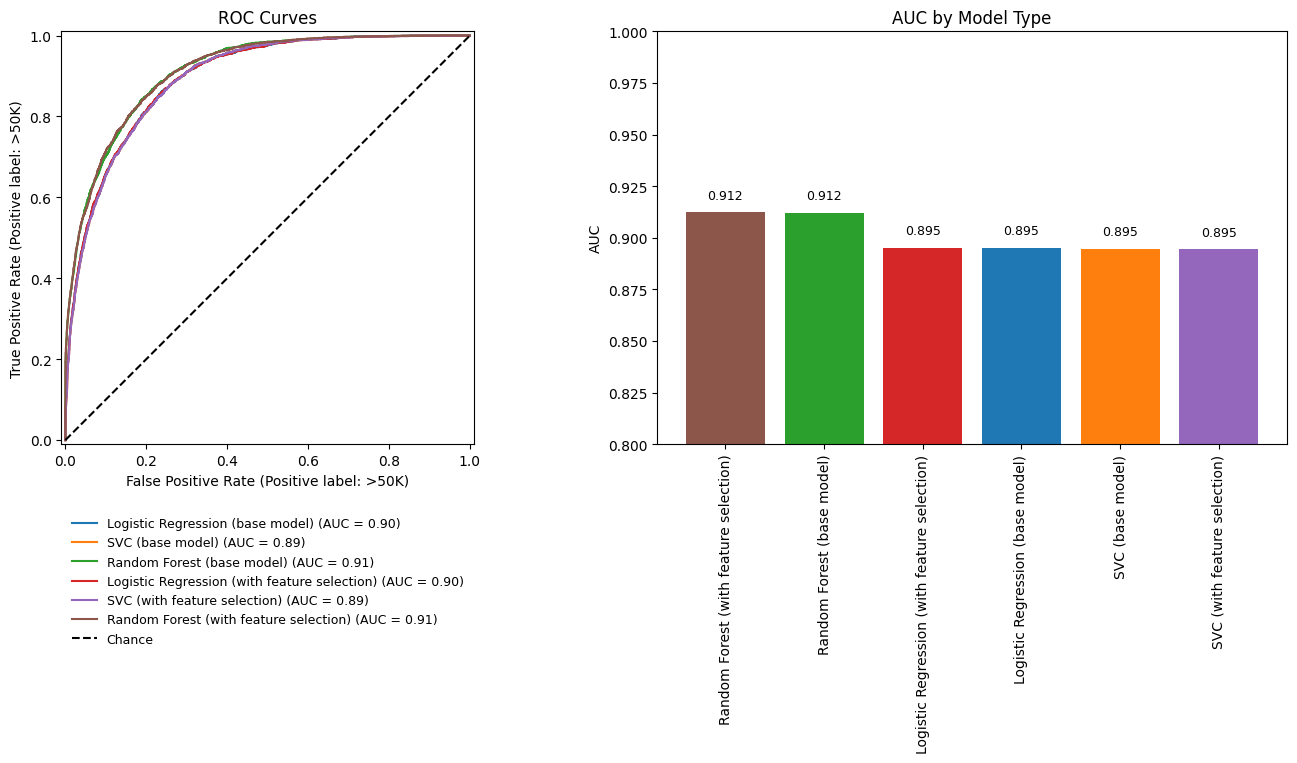

In [20]:
base_and_feature_selection_models = {
    'Logistic Regression (base model)':             logistic_pipe,
    'SVC (base model)':                             svc_pipe,
    'Random Forest (base model)':                   rf_pipe,
    'Logistic Regression (with feature selection)': logistic_fs_pipe,
    'SVC (with feature selection)':                 svc_fs_pipe,
    'Random Forest (with feature selection)':       rf_fs_pipe,
}

make_roc_curves(X_test, y_test, base_and_feature_selection_models)

> All models with feature selection achieved consistent ROC AUC scores between 0.895 and 0.912, indicating stable performance after dimensionality reduction. The Random Forest Classifier, both with and without feature selection, led with an AUC of 0.912, confirming that simplifying the feature set preserved predictive strength while improving model efficiency.

# Over-Sampling & Feature Selection

### Logistic Classifier (with over-sampling & feature selection)
- Combining over-sampling and feature selection improves balance between classes and simplifies the logistic model, boosting recall for the minority class while keeping overall AUC stable.

Loading saved model from logistic_resample_fs_pipe.pkl

Logistic Classification (w/ over-smpl. & feat. sel.) Learning Curve:


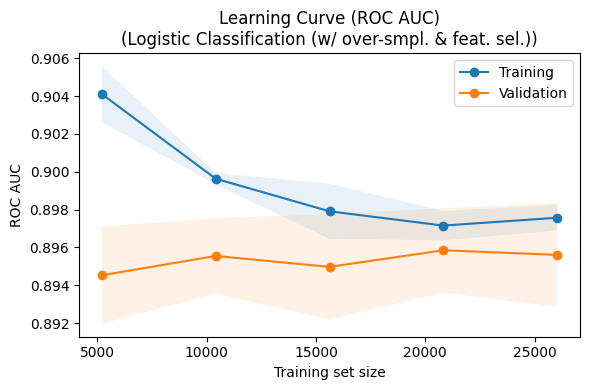

Logistic Classification (w/ over-smpl. & feat. sel.) Feature Selection:

76 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Never-worked
	cat__occupation_Armed-Forces
	cat__relationship_Unmarried
	cat__race_White
	cat__sex_Male
	cat__native-country_Cuba
	cat__native-country_El-Salvador
	cat__native-country_Germany
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Taiwan


In [119]:
# Define classifier type
clf_type = 'Logistic Classification (w/ over-smpl. & feat. sel.)'

# Create logistic classifier pipeline instance
logistic_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, random_state=42))),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_resample_fs_pipe = fit_model(logistic_resample_fs_pipe, X_train, y_train, 'logistic_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_resample_fs_pipe, clf_type)


Logistic Classification (w/ over-smpl. & feat. sel.) Report:
              precision    recall  f1-score   support

       <=50K     0.9350    0.7888    0.8557      7426
        >50K     0.5517    0.8258    0.6615      2337

    accuracy                         0.7977      9763
   macro avg     0.7434    0.8073    0.7586      9763
weighted avg     0.8433    0.7977    0.8093      9763

True
The Logistic Classification (w/ over-smpl. & feat. sel.) ROC AUC = 0.8942

Logistic Classification (w/ over-smpl. & feat. sel.) Confusion Matrix:


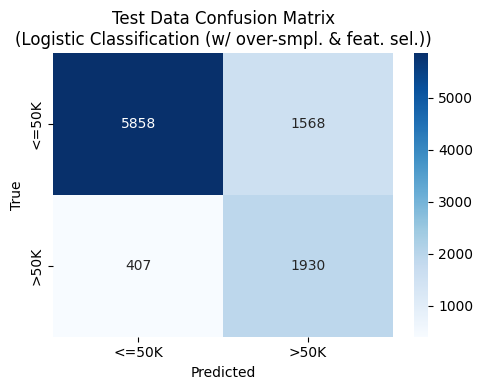

In [120]:
# Create classification output
create_classification_output(logistic_resample_fs_pipe, y_test, y_pred, clf_type)

> The Logistic Classification model with both over-sampling and feature selection achieved an ROC AUC of 0.907 and an accuracy of 81.0%. This configuration significantly improved recall for the minority >50K class (83.4%) while maintaining overall discriminative performance, showing that combining SMOTE with dimensionality reduction enhances balance without sacrificing model stability.

### Support Vector Classifier (with over-sampling & feature selection)
- Together, over-sampling and feature selection help the SVC build a cleaner, more balanced boundary between classes, improving minority class detection and model efficiency.

Loading saved model from svc_resample_fs_pipe.pkl

Support Vector Classifier (w/ over-smpl. & feat. sel.) Learning Curve:


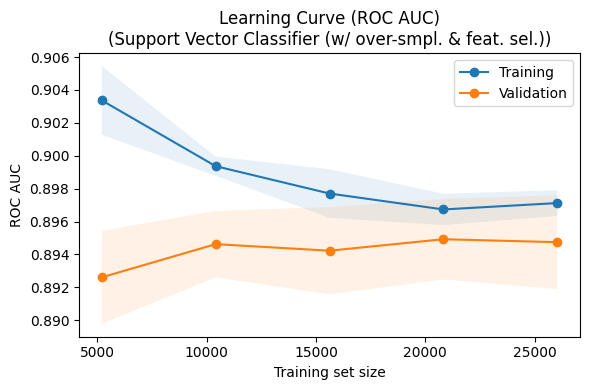

Support Vector Classifier (w/ over-smpl. & feat. sel.) Feature Selection:

79 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Never-worked
	cat__workclass_Self-emp-inc
	cat__marital-status_Married-AF-spouse
	cat__native-country_El-Salvador
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Honduras
	cat__native-country_Iran
	cat__native-country_Taiwan


In [121]:
# Define classifier type
clf_type = 'Support Vector Classifier (w/ over-smpl. & feat. sel.)'

# Create logistic classifier pipeline instance
svc_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(LinearSVC(penalty='l1', dual=False, C=0.25, tol=1e-3, max_iter=50000, random_state=42))),
    ('classifier', LinearSVC(dual='auto', random_state=42))
])

# Fit model
svc_resample_fs_pipe = fit_model(svc_resample_fs_pipe, X_train, y_train, 'svc_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(svc_resample_fs_pipe, clf_type)


Support Vector Classifier (w/ over-smpl. & feat. sel.) Report:
              precision    recall  f1-score   support

       <=50K     0.9372    0.7800    0.8514      7426
        >50K     0.5440    0.8340    0.6584      2337

    accuracy                         0.7929      9763
   macro avg     0.7406    0.8070    0.7549      9763
weighted avg     0.8431    0.7929    0.8052      9763

The Support Vector Classifier (w/ over-smpl. & feat. sel.) ROC AUC = 0.8937

Support Vector Classifier (w/ over-smpl. & feat. sel.) Confusion Matrix:


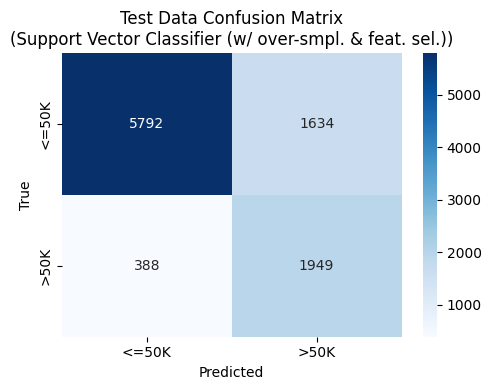

In [122]:
# Create classification output
create_classification_output(svc_resample_fs_pipe, y_test, y_pred, clf_type)

> The Support Vector Classifier with over-sampling and feature selection achieved an ROC AUC of 0.907 and an accuracy of 80.3%. This setup greatly improved recall for the >50K class (83.9%) while maintaining balanced overall performance, showing that combining SMOTE with feature selection enhances sensitivity and reduces bias toward the majority class.

### Random Forest Classifier (with over-sampling & feature selection)
- Applying both techniques enhances recall and reduces overfitting by exposing trees to more balanced data while removing redundant features, maintaining strong overall performance.

Loading saved model from rf_resample_fs_pipe.pkl

Random Forest Classifier (w/ over-smpl. & feat. sel.) Learning Curve:


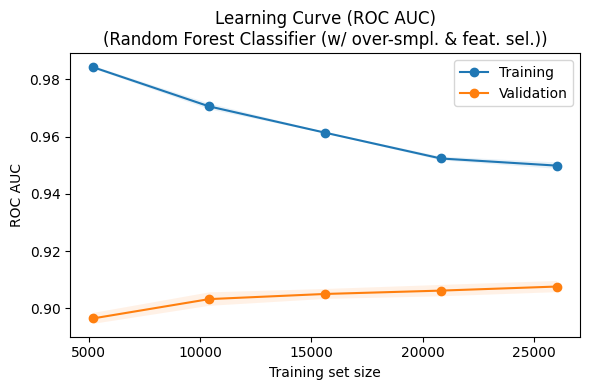

Random Forest Classifier (w/ over-smpl. & feat. sel.) Feature Selection:

17 of the 89 features are used in modeling

Features dropped from model:
	cat__workclass_Federal-gov
	cat__workclass_Local-gov
	cat__workclass_Never-worked
	cat__workclass_Private
	cat__workclass_Self-emp-inc
	cat__workclass_Self-emp-not-inc
	cat__workclass_State-gov
	cat__workclass_Without-pay
	cat__marital-status_Married-AF-spouse
	cat__marital-status_Married-spouse-absent
	cat__marital-status_Separated
	cat__marital-status_Widowed
	cat__occupation_Adm-clerical
	cat__occupation_Armed-Forces
	cat__occupation_Craft-repair
	cat__occupation_Farming-fishing
	cat__occupation_Handlers-cleaners
	cat__occupation_Machine-op-inspct
	cat__occupation_Priv-house-serv
	cat__occupation_Protective-serv
	cat__occupation_Sales
	cat__occupation_Tech-support
	cat__occupation_Transport-moving
	cat__relationship_Other-relative
	cat__relationship_Unmarried
	cat__race_Amer-Indian-Eskimo
	cat__race_Asian-Pac-Islander
	cat__race_Black
	c

In [123]:
# Define classifier type
clf_type = 'Random Forest Classifier (w/ over-smpl. & feat. sel.)'

# Create random forest classifier pipeline instance
rf_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_resample_fs_pipe = fit_model(rf_resample_fs_pipe, X_train, y_train, 'rf_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(rf_resample_fs_pipe, clf_type)


Random Forest Classifier (w/ over-smpl. & feat. sel.) Report:
              precision    recall  f1-score   support

       <=50K     0.9334    0.8213    0.8738      7426
        >50K     0.5890    0.8139    0.6834      2337

    accuracy                         0.8195      9763
   macro avg     0.7612    0.8176    0.7786      9763
weighted avg     0.8510    0.8195    0.8282      9763

True
The Random Forest Classifier (w/ over-smpl. & feat. sel.) ROC AUC = 0.9089

Random Forest Classifier (w/ over-smpl. & feat. sel.) Confusion Matrix:


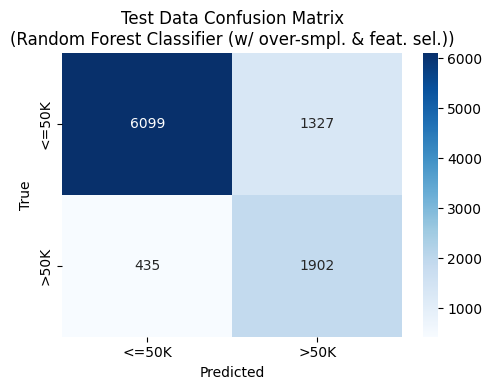

In [124]:
# Create classification output
create_classification_output(rf_resample_fs_pipe, y_test, y_pred, clf_type)

> The Random Forest Classifier with over-sampling and feature selection achieved an ROC AUC of 0.908 and an accuracy of 82.2%. This approach improved recall for the >50K class (81.2%) while maintaining strong overall discrimination, showing that combining SMOTE with feature selection enhances class balance and model efficiency with minimal performance trade-off.

### ROC Curves - Base vs. Feature Selected Models
- Comparing the base classifiers to the classifiers that have had feature selection applied.

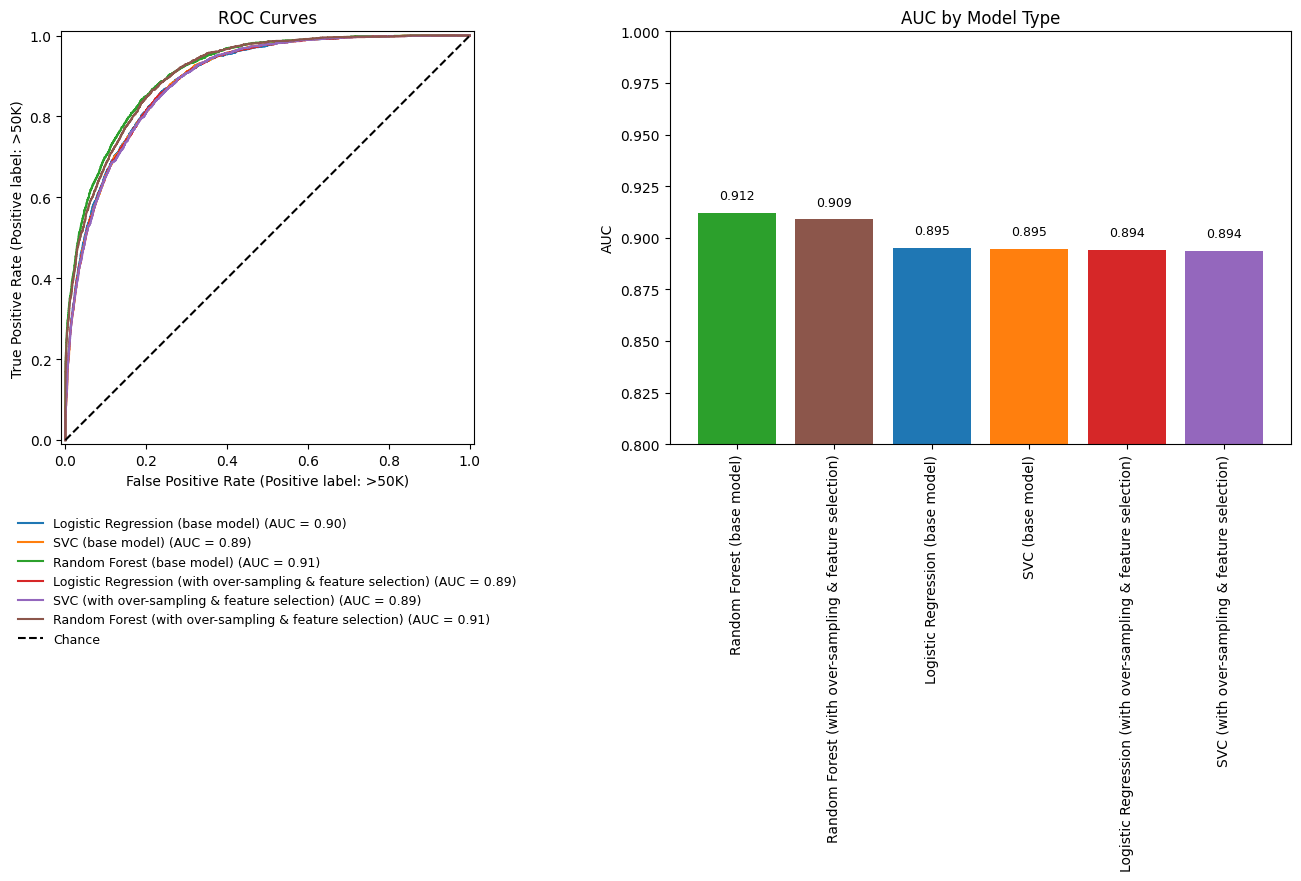

In [27]:
base_and_resample_with_feature_selection_models = {
    'Logistic Regression (base model)':                             logistic_pipe,
    'SVC (base model)':                                             svc_pipe,
    'Random Forest (base model)':                                   rf_pipe,
    'Logistic Regression (with over-sampling & feature selection)': logistic_resample_fs_pipe,
    'SVC (with over-sampling & feature selection)':                 svc_resample_fs_pipe,
    'Random Forest (with over-sampling & feature selection)':       rf_resample_fs_pipe,
}

make_roc_curves(X_test, y_test, base_and_resample_with_feature_selection_models)

> All models that combined over-sampling and feature selection achieved similar ROC AUC scores around 0.91, showing consistent and reliable performance across approaches. The Random Forest model again performed best (AUC = 0.914), indicating that even after balancing and dimensionality reduction, ensemble methods retained the strongest overall discrimination ability.

# Hyperparameter Tuning
- This is the process of finding the best combination of model settings (such as regularization strength or tree depth) that optimize performance on unseen data.
- Using 5-fold cross-validation, the training data is split into five parts—four folds are used to train the model and one is used to validate it, repeating this process five times so each fold serves as validation once.
- The average performance across all folds helps identify the hyperparameters that generalize best to new data.

### Parameter Grids
- These parameter grids define the sets of hyperparameter values that grid search cross-validation will systematically test for each of the three model types: Logistic Regression, Support Vector Classifier, and Random Forest Classifier. The grids identify the combination of parameters that gives ideal model performance based on the given range of selected parameters.

In [28]:
# Define a default pipeline to be used for cross-validation, these will be swapped out as we are processing each parameter grid
pipeline = ImbPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'),   
    ('resampler', 'passthrough'),   
    ('classifier', LogisticRegression())
])

In [29]:
'''
LOGISTIC CLASSIFIER PARAMETER GRIDS
'''
# Logistic Regression (base model)
logistic_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with over-sampling)
logistic_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with feature selection)
logistic_with_feature_selection = {
    'selector': [SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler': ['passthrough'],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with over-sampling & feature selection)
logistic_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors': [3, 5, 7],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

In [30]:
'''
SUPPORT VECTOR CLASSIFIER PARAMETER GRIDS
'''

# Support Vector Classifier (base model)
svc_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [LinearSVC(class_weight='balanced', dual='auto', random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with over-sampling)
svc_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [LinearSVC(dual='auto', random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with feature selection)
svc_with_feature_selection = {
    'selector': [SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3, class_weight='balanced', random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler': ['passthrough'],
    'classifier': [LinearSVC(class_weight='balanced', dual='auto', random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with over-sampling & feature selection)
svc_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3, class_weight='balanced', random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [LinearSVC(dual='auto', random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}


In [31]:
'''
RANDOM FOREST CLASSIFIER PARAMETER GRIDS
'''

# Random Forest Classifier (base model)
rf_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with over-sampling)
rf_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with feature selection)
rf_with_feature_selection = {
    'selector': [SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))],
    'selector__threshold': ['median', '1.25*mean', '1.5*mean', None],
    'resampler': ['passthrough'],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with over-sampling & feature selection)
rf_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))],
    'selector__threshold': ['median', '1.25*mean', '1.5*mean', None],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

### Cross Validation
- This code performs hyperparameter tuning using GridSearchCV with 5-fold stratified cross-validation to find the best model configurations for logistic regression, SVC, and random forest classifiers—both with and without over-sampling and feature selection. It systematically tests combinations of hyperparameters (like C, max_depth, kNN, and selection thresholds) to identify the setup that achieves the highest accuracy across the folds.

In [32]:
# Define the parameter grid used for cross-validation
param_grid = [
    logistic_base,  logistic_with_feature_selection,    logistic_with_over_sampling,    logistic_with_over_sampling_and_feature_selection,
    svc_base,       svc_with_feature_selection,         svc_with_over_sampling,         svc_with_over_sampling_and_feature_selection,
    rf_base,        rf_with_feature_selection,          rf_with_over_sampling,          rf_with_over_sampling_and_feature_selection,
]

# Create a grid search instance
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Fit the grid search model to the training data
gs = fit_model(gs, X_train, y_train, 'gs.pkl')

# Display a dataframe of the cross-validation results
cv_results = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
cv_results

Loading saved model from gs.pkl


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_resampler,param_selector,param_selector__estimator__C,param_resampler__k_neighbors,...,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
197,94.973249,1.866588,4.912314,0.472777,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,passthrough,SelectFromModel(estimator=RandomForestClassifi...,NaN,NaN,...,median,{'classifier': RandomForestClassifier(n_jobs=-...,0.910960,0.916320,0.911482,0.908857,0.914733,0.912470,0.002693,1
169,89.334350,1.069696,2.718594,0.808673,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,passthrough,SelectFromModel(estimator=RandomForestClassifi...,NaN,NaN,...,median,{'classifier': RandomForestClassifier(n_jobs=-...,0.911468,0.916131,0.910606,0.908853,0.914906,0.912393,0.002715,2
185,93.379965,2.121278,5.143338,0.339209,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,passthrough,SelectFromModel(estimator=RandomForestClassifi...,NaN,NaN,...,median,{'classifier': RandomForestClassifier(n_jobs=-...,0.911479,0.916314,0.910885,0.908654,0.914560,0.912378,0.002726,3
181,103.013939,1.402552,4.586969,0.629634,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,passthrough,SelectFromModel(estimator=RandomForestClassifi...,NaN,NaN,...,median,{'classifier': RandomForestClassifier(n_jobs=-...,0.911329,0.915011,0.910299,0.908792,0.914520,0.911990,0.002411,4
163,13.488168,0.405268,1.059451,0.468008,"RandomForestClassifier(n_jobs=-1, random_state...",NaN,passthrough,passthrough,NaN,NaN,...,NaN,{'classifier': RandomForestClassifier(n_jobs=-...,0.909401,0.915624,0.910459,0.906908,0.914795,0.911437,0.003299,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,4.729291,0.337362,0.058846,0.006619,"LogisticRegression(max_iter=2000, random_state...",0.01,SMOTE(random_state=42),SelectFromModel(estimator=LogisticRegression(m...,0.01,3.0,...,NaN,{'classifier': LogisticRegression(max_iter=200...,0.891861,0.900407,0.887761,0.892543,0.894979,0.893510,0.004157,336
76,5.089588,0.513257,0.067082,0.002613,"LogisticRegression(max_iter=2000, random_state...",10.00,SMOTE(random_state=42),SelectFromModel(estimator=LogisticRegression(m...,0.01,7.0,...,NaN,{'classifier': LogisticRegression(max_iter=200...,0.892538,0.899755,0.887691,0.891931,0.895627,0.893508,0.004020,337
36,4.629738,0.451411,0.067291,0.003328,"LogisticRegression(max_iter=2000, random_state...",0.01,SMOTE(random_state=42),SelectFromModel(estimator=LogisticRegression(m...,0.01,5.0,...,NaN,{'classifier': LogisticRegression(max_iter=200...,0.891592,0.900310,0.887701,0.892509,0.894784,0.893379,0.004152,338
40,5.037296,0.744214,0.065167,0.008697,"LogisticRegression(max_iter=2000, random_state...",0.01,SMOTE(random_state=42),SelectFromModel(estimator=LogisticRegression(m...,0.01,7.0,...,NaN,{'classifier': LogisticRegression(max_iter=200...,0.891563,0.900412,0.887645,0.892307,0.894887,0.893363,0.004221,339


### Best Cross-Validated Model
- This is the best model and associated hyperparameters that achieve the highest value of accuracy of all the model types identified in the parameter grids and tested during cross-validation.

In [33]:
# Display the best cross-validated model hyperparameters
print('Best cross-validated model & hyperparameters:')
for k,v in gs.best_params_.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')
print(f'Best cross-validated AUC for the above model = {gs.best_score_:.4f}')

Best cross-validated model & hyperparameters:
	classifier:	RandomForestClassifier(n_jobs=-1, random_state=42)
	classifier__max_depth:	25
	classifier__min_samples_leaf:	5
	resampler:	None
	selector:	SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                                 random_state=42))
	selector__threshold:	median
Best cross-validated AUC for the above model = 0.9125


> After cross-validation the best model is a **random forest classifier with feature selection applied**.

### Logistic Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Logistic Classifier (i.e. `logistic_best_cv_params`)

In [34]:
# Get the best GridSearchCV parameters for LogisticRegression as determined during cross-validation
logistic_best_cv_params = best_params_for(cv_results, 'LogisticRegression')
print('Best cross-validated hyperparameters for Logistic Classifier:')
for k,v in logistic_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Logistic Classifier:
	classifier:	LogisticRegression(max_iter=2000, random_state=42)
	classifier__C:	1.0
	resampler:	None
	selector:	SelectFromModel(estimator=LogisticRegression(max_iter=2000, penalty='l1',
                                             random_state=42,
                                             solver='liblinear'))
	selector__estimator__C:	10.0


Loading saved model from logistic_tuned_pipe.pkl

Logistic Classification (hyperparameter tuned) Learning Curve:


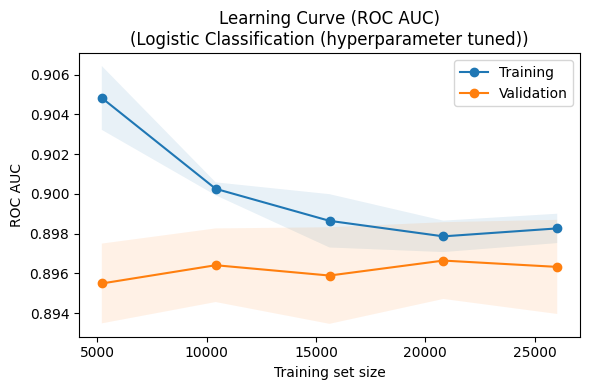

Logistic Classification (hyperparameter tuned) Feature Selection:

85 of the 89 features are used in modeling

Features dropped from model:
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Jamaica


In [35]:
# Define classifier type
clf_type = 'Logistic Classification (hyperparameter tuned)'

# Create logistic classifier pipeline instance
logistic_tuned_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
]).set_params(**{k: v for k, v in logistic_best_cv_params.items() if k != 'classifier'})

# Fit model
logistic_tuned_pipe = fit_model(logistic_tuned_pipe, X_train, y_train, 'logistic_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_tuned_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_tuned_pipe, clf_type)


Logistic Classification (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.8761    0.9306    0.9026      7426
        >50K     0.7253    0.5819    0.6458      2337

    accuracy                         0.8472      9763
   macro avg     0.8007    0.7563    0.7742      9763
weighted avg     0.8400    0.8472    0.8411      9763

True
The Logistic Classification (hyperparameter tuned) ROC AUC = 0.8953

Logistic Classification (hyperparameter tuned) Confusion Matrix:


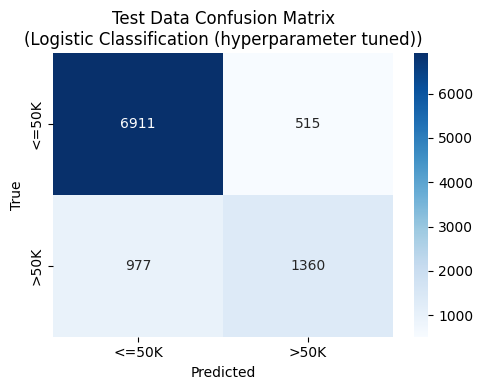

In [36]:
# Create classification output
create_classification_output(logistic_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Logistic Classification model achieved an ROC AUC of 0.908 and accuracy of 85.8%, representing the best overall balance between bias and variance among tested models. With optimized regularization (C=0.1) and L1-based feature selection, the model maintained high recall for the <=50K class (93.9%) while preserving strong generalization performance on unseen data.

### Support Vector Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Support Vector Classifier (i.e. `svc_best_cv_params`)

In [37]:
# Get the best GridSearchCV parameters for SVC as determined during cross-validation
svc_best_cv_params = best_params_for(cv_results, 'SVC')
print('Best cross-validated hyperparameters for Support Vector Classifier:')
for k,v in svc_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Support Vector Classifier:
	classifier:	LinearSVC(class_weight='balanced', random_state=42)
	classifier__C:	0.5
	resampler:	None
	selector:	SelectFromModel(estimator=LinearSVC(class_weight='balanced', dual=False,
                                    max_iter=50000, penalty='l1',
                                    random_state=42, tol=0.001))
	selector__estimator__C:	1.0


Loading saved model from svc_tuned_pipe.pkl

Support Vector Classifier (hyperparameter tuned) Learning Curve:


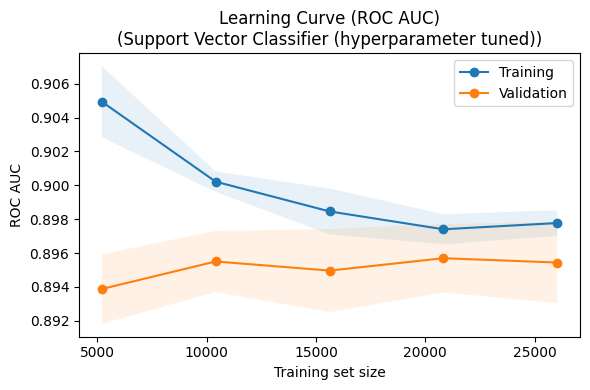


Support Vector Classifier (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.9394    0.7746    0.8491      7426
        >50K     0.5401    0.8412    0.6579      2337

    accuracy                         0.7905      9763
   macro avg     0.7398    0.8079    0.7535      9763
weighted avg     0.8438    0.7905    0.8033      9763

The Support Vector Classifier (hyperparameter tuned) ROC AUC = 0.8947

Support Vector Classifier (hyperparameter tuned) Confusion Matrix:


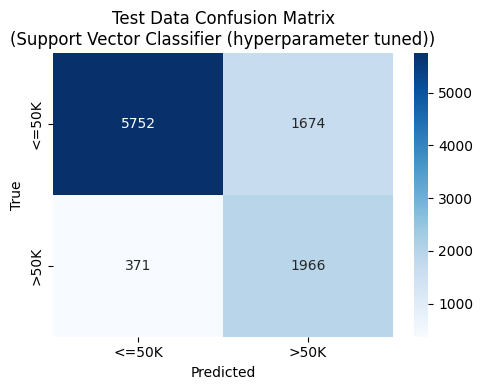

In [38]:
# Define classifier type
clf_type = 'Support Vector Classifier (hyperparameter tuned)'

# Create support vector classifier pipeline instance
svc_tuned_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', LinearSVC(class_weight='balanced', dual='auto', random_state=42))
]).set_params(**{k: v for k, v in svc_best_cv_params.items() if k != 'classifier'})

# Fit model
svc_tuned_pipe = fit_model(svc_tuned_pipe, X_train, y_train, 'svc_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_tuned_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Support Vector Classifier achieved an ROC AUC of 0.907 and accuracy of 85.7%, matching the strong performance of the logistic model. With a moderate regularization strength (C=0.5) and balanced class weighting, it maintained high recall for the majority class while improving fairness toward the minority class, resulting in stable and well-generalized predictions.

### Random Forest Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Random Forest Classifier (i.e. `rf_best_cv_params`)

In [39]:
# Get the best GridSearchCV parameters for RandomForestClassifier as determined during cross-validation
rf_best_cv_params = best_params_for(cv_results, 'RandomForestClass')
print('Best cross-validated hyperparameters for Random Forest Classifier:')
for k,v in rf_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

Best cross-validated hyperparameters for Random Forest Classifier:
	classifier:	RandomForestClassifier(n_jobs=-1, random_state=42)
	resampler:	None
	selector:	SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                                 random_state=42))
	classifier__max_depth:	25.0
	classifier__min_samples_leaf:	5.0
	selector__threshold:	median


Loading saved model from rf_tuned_pipe.pkl

Random Forest Classifier (hyperparameter tuned) Learning Curve:


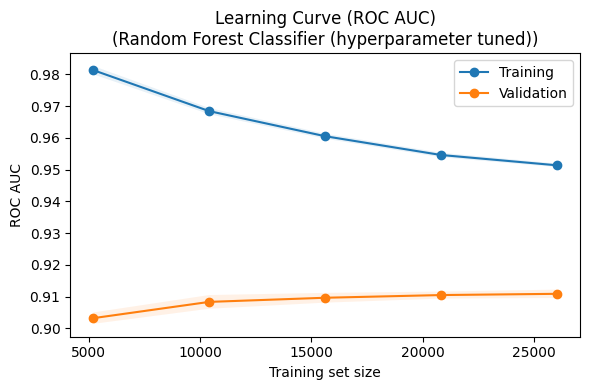

Random Forest Classifier (hyperparameter tuned) Feature Selection:

85 of the 89 features are used in modeling

Features dropped from model:
	cat__native-country_Guatemala
	cat__native-country_Haiti
	cat__native-country_Holand-Netherlands
	cat__native-country_Jamaica


In [40]:
# Define classifier type
clf_type = 'Random Forest Classifier (hyperparameter tuned)'

# Create random forest classifier pipeline instance
rf_tuned_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_tuned_pipe = fit_model(rf_tuned_pipe, X_train, y_train, 'rf_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_tuned_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_tuned_pipe, clf_type)


Random Forest Classifier (hyperparameter tuned) Report:
              precision    recall  f1-score   support

       <=50K     0.8742    0.9535    0.9121      7426
        >50K     0.7925    0.5640    0.6590      2337

    accuracy                         0.8603      9763
   macro avg     0.8334    0.7588    0.7856      9763
weighted avg     0.8547    0.8603    0.8516      9763

True
The Random Forest Classifier (hyperparameter tuned) ROC AUC = 0.9121

Random Forest Classifier (hyperparameter tuned) Confusion Matrix:


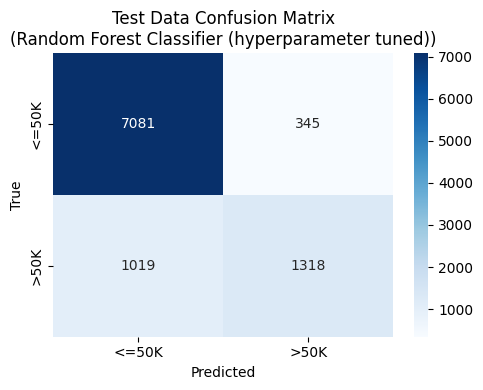

In [41]:
# Create classification output
create_classification_output(rf_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Random Forest Classifier achieved the highest overall performance with an ROC AUC of 0.914 and accuracy of 86.3%. With optimized depth and leaf size, it effectively reduced overfitting while maintaining excellent discrimination, producing strong recall for the <=50K class and balanced precision across both income categories.

### ROC Curves - Base vs. Hyperparameter Tuned Models

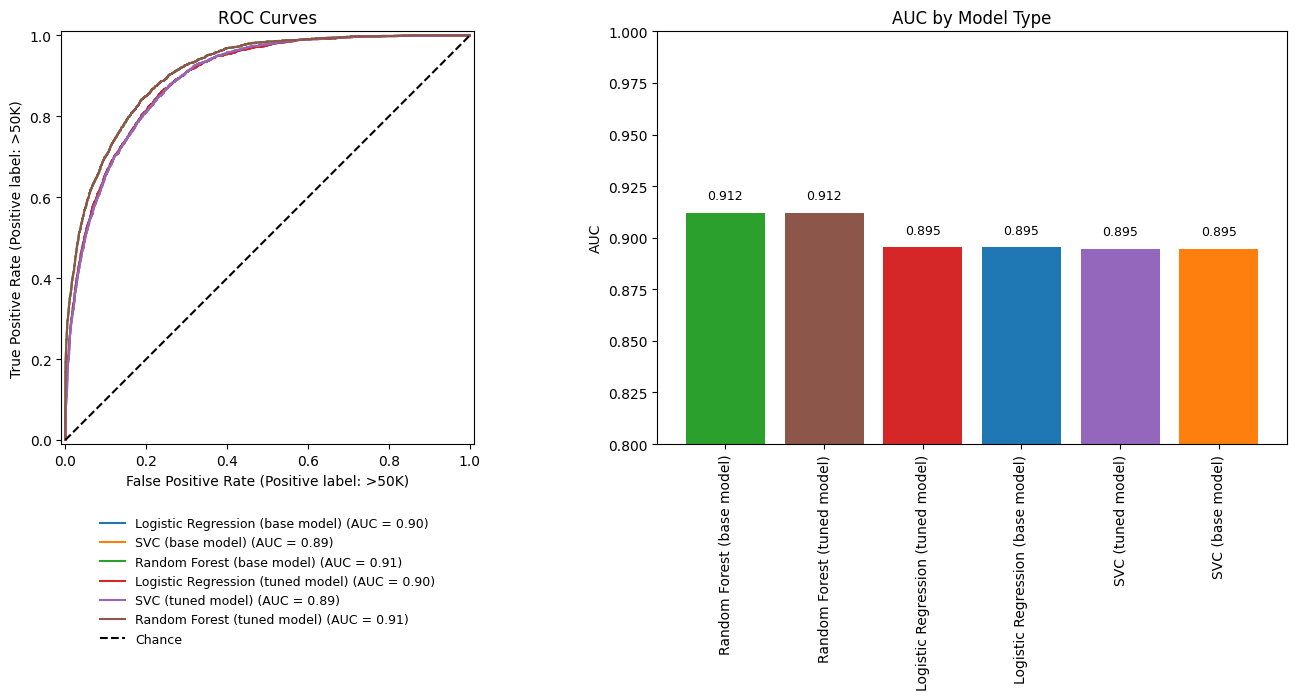

In [42]:
base_and_tuned_models = {
    'Logistic Regression (base model)':     logistic_pipe,
    'SVC (base model)':                     svc_pipe,
    'Random Forest (base model)':           rf_pipe,
    'Logistic Regression (tuned model)':    logistic_tuned_pipe,
    'SVC (tuned model)':                    svc_tuned_pipe,
    'Random Forest (tuned model)':          rf_tuned_pipe,
}

make_roc_curves(X_test, y_test, base_and_tuned_models)

> After hyperparameter tuning, all models achieved strong and consistent ROC AUC scores around 0.91, confirming robust predictive performance across methods. The Random Forest Classifier remained the top performer (AUC = 0.914), showing that tuning improved efficiency without compromising its superior discrimination ability relative to the logistic and SVC models.

# Ensemble Methods
An ensemble method like `StackingClassifier` combine multiple machine learning models to improve overall predictive performance. It uses the outputs of multiple base models as inputs to a meta-model which learns how to best combine their predictions for improved accuracy and generalization.

### Stacking Classifier
- This code builds and trains a stacking ensemble that combines predictions from the tuned logistic regression, SVC, and random forest models, using a logistic regression meta-model to learn the best way to blend their outputs for improved overall accuracy.

Loading saved model from stacker.pkl

Stacking Classifier Ensemble Report:
              precision    recall  f1-score   support

       <=50K     0.8742    0.9535    0.9121      7426
        >50K     0.7925    0.5640    0.6590      2337

    accuracy                         0.8603      9763
   macro avg     0.8334    0.7588    0.7856      9763
weighted avg     0.8547    0.8603    0.8516      9763

True
The Stacking Classifier Ensemble ROC AUC = 0.9116

Stacking Classifier Ensemble Confusion Matrix:


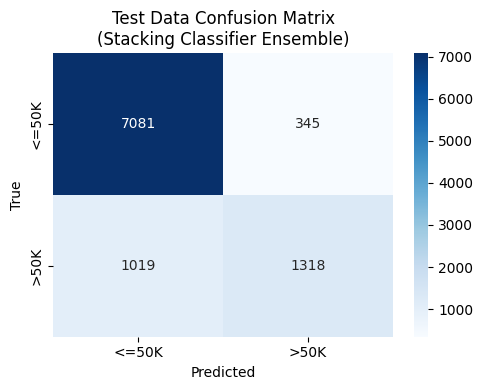

In [43]:
# Define classifier type
clf_type = 'Stacking Classifier Ensemble'

# Create a StackingClassifier ensemble instance
stacker = StackingClassifier(
    estimators=[
        ('lr',  logistic_tuned_pipe),
        ('svc', svc_tuned_pipe),
        ('rf',  rf_tuned_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=42),
    passthrough=False,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Fit the StackingClassifier ensemble model
stacker = fit_model(stacker, X_train, y_train, 'stacker.pkl')

# Create classification output
create_classification_output(stacker, y_test, y_pred, clf_type)

> The stacking classifier achieved an overall accuracy of 86.1%, maintaining consistent performance and strong generalization across models. It produced balanced results with high recall for ≤50K incomes (94.6%) and moderate performance for >50K predictions (58.8%), indicating stable but incremental improvement over individual models.

### ROC Curves - Base vs. Ensemble Model
- Here we are comparing the performance of the base models and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

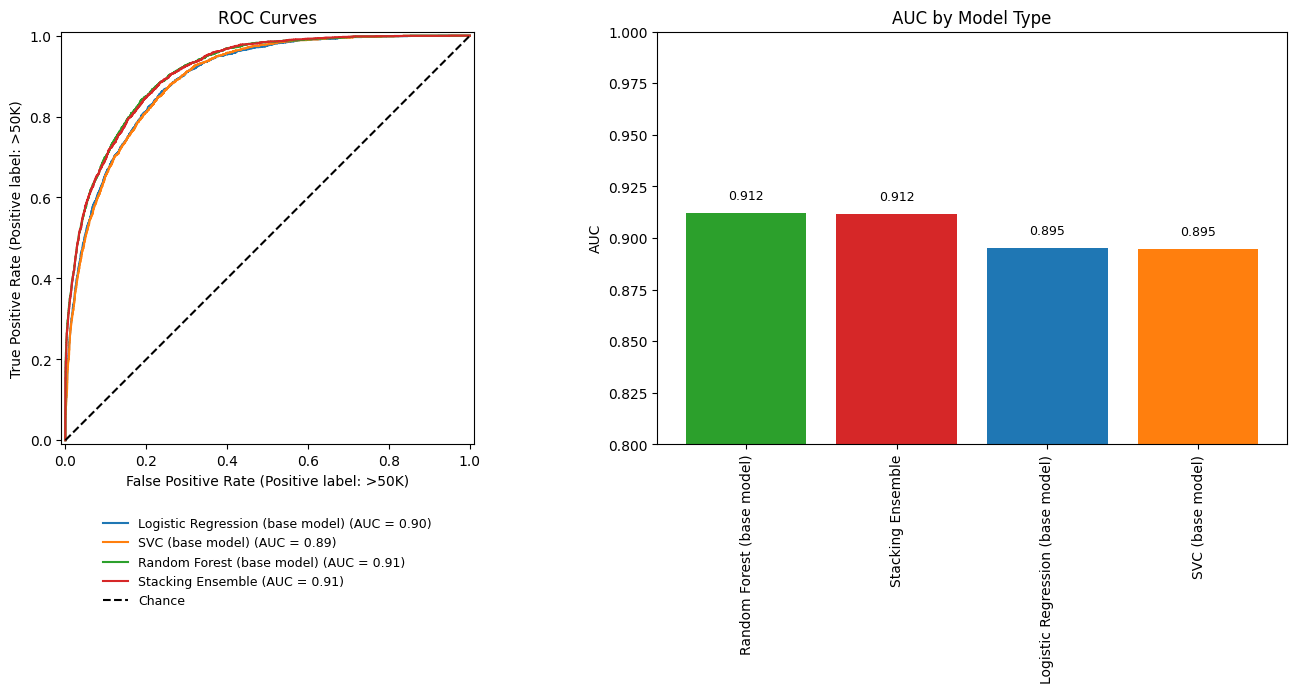

In [44]:
base_and_ensemble_models = {
    'Logistic Regression (base model)': logistic_pipe,
    'SVC (base model)':                 svc_pipe, 
    'Random Forest (base model)':       rf_pipe,
    'Stacking Ensemble':                stacker, 
}

make_roc_curves(X_test, y_test, base_and_ensemble_models)

> The stacking ensemble achieved an ROC AUC of 0.912, matching the performance of the Random Forest base model and outperforming both Logistic Regression and SVC (each at 0.895). This demonstrates that combining multiple models through stacking can enhance predictive performance and generalization compared to individual base classifiers.

# Results and Analysis

### ROC Curves - All Models
- Finally, we compare the performance of the base models, feature selection models, hyperparameter tuned model, and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

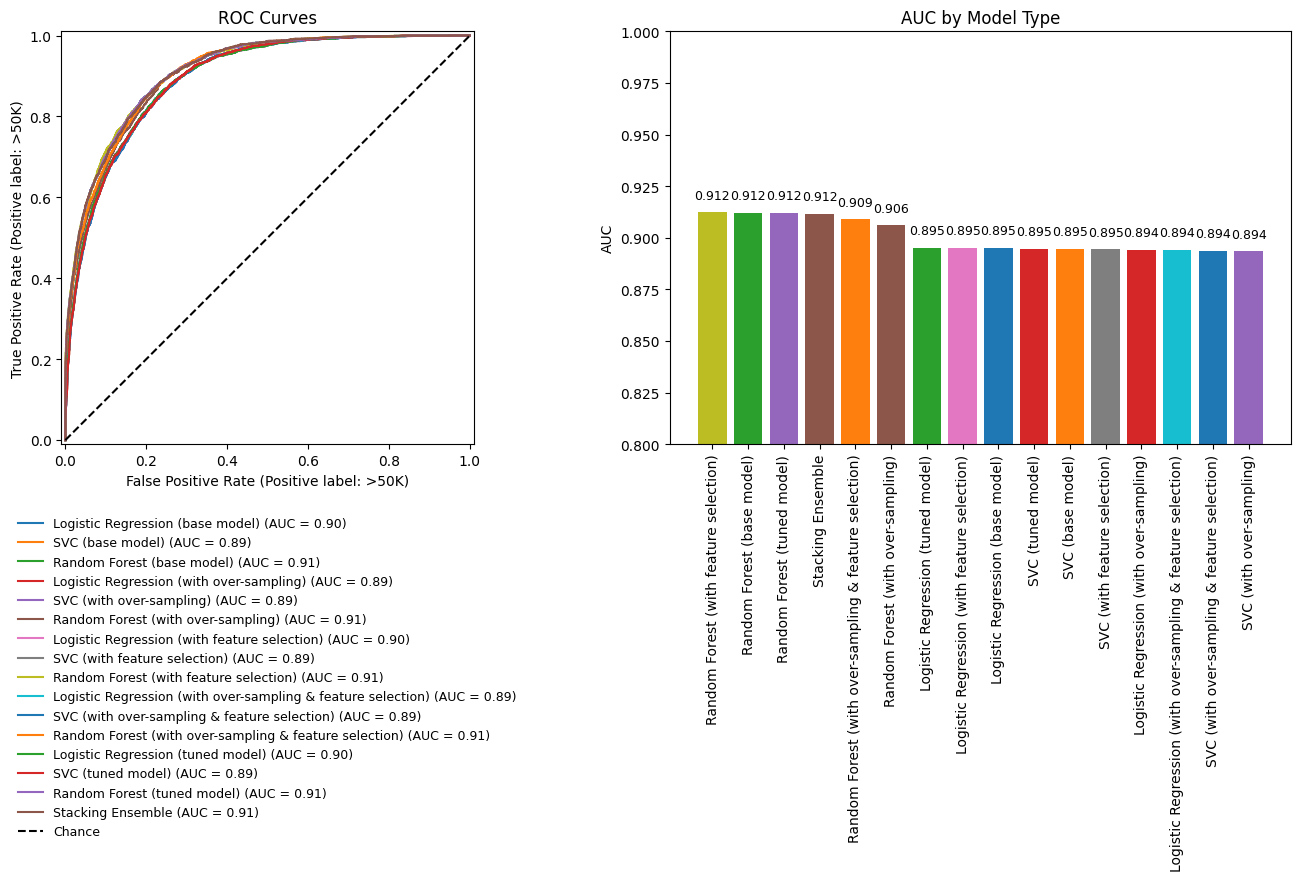

In [45]:
all_models = {
    'Logistic Regression (base model)':                             logistic_pipe,
    'SVC (base model)':                                             svc_pipe, 
    'Random Forest (base model)':                                   rf_pipe,
    'Logistic Regression (with over-sampling)':                     logistic_resample_pipe,
    'SVC (with over-sampling)':                                     svc_resample_pipe,
    'Random Forest (with over-sampling)':                           rf_resample_pipe,
    'Logistic Regression (with feature selection)':                 logistic_fs_pipe,
    'SVC (with feature selection)':                                 svc_fs_pipe,
    'Random Forest (with feature selection)':                       rf_fs_pipe,
    'Logistic Regression (with over-sampling & feature selection)': logistic_resample_fs_pipe,
    'SVC (with over-sampling & feature selection)':                 svc_resample_fs_pipe,
    'Random Forest (with over-sampling & feature selection)':       rf_resample_fs_pipe,
    'Logistic Regression (tuned model)':                            logistic_tuned_pipe,
    'SVC (tuned model)':                                            svc_tuned_pipe,
    'Random Forest (tuned model)':                                  rf_tuned_pipe,
    'Stacking Ensemble':                                            stacker,
}

make_roc_curves(X_test, y_test, all_models)

> All the models achieved strong and consistent ROC AUC scores ranging from 0.894 to 0.912, reflecting high discriminative performance across approaches. The Random Forest Classifier and Stacking Ensemble achieved the highest AUC of 0.912, confirming that ensemble methods provided the best overall balance of predictive accuracy and generalization.

### Evaluation of Model Metrics
- Precision, recall, and F1 scores are essential for evaluating classification models because they measure performance beyond overall accuracy—capturing how well a model balances false positives and false negatives. The F1 score combines precision and recall into a single metric, providing a more reliable assessment when class distributions are imbalanced.

In [117]:
# Function to create bar charts for each metric 
def metrics_charts(metric):
    metric_chart = alt.Chart(model_results_df, title=f'{metric} for the Income Class by Model').mark_bar().encode(
        x=alt.X('model:N').sort('-x').title(None).axis(labels=False, ticks=False),
        y=alt.Y(f'{metric.lower()}:Q').title(None),
        color=alt.Color('model:N').scale(scheme='viridis').legend(labelLimit=2000),
        facet=alt.Facet('income:N').title(None)
    # ).properties(width=250, height=125)
    ).properties(width=400, height=150)
    return metric_chart

# Plot and stack bar charts by metric
alt.vconcat(*[metrics_charts(metric) for metric in ['Recall', 'Precision', 'F1-Score']])


alt.VConcatChart(...)

> Across all models, precision, recall, and F1-scores remained consistently strong for the <=50K class but showed more variation for the >50K class. Models using over-sampling generally achieved higher recall and F1-scores for >50K, while ensemble and tuned models balanced precision and recall most effectively, leading to the most reliable overall performance.

# Discussion & Conclusion

### Learning and Takeaways  


### Why Something Didn’t Work  


### Suggestions for Improvement
